In [1]:
hc


Sparkling Water Context:
 * Sparkling Water Version: 3.30.0.1-1-2.4
 * H2O name: admin
 * cluster size: 4
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,100.96.3.7,54321)
  (1,100.96.4.8,54321)
  (2,100.96.5.9,54321)
  (3,100.96.2.11,54321)
  ------------------------

  Open H2O Flow in browser: http://notebook:54323 (CMD + click in Mac OSX)

    


In [4]:
# Import H2O Python library
import h2o
# View all the available H2O python functions
#dir(h2o)

# Parse Chicago Crime dataset into H2O
column_type = ['numeric','string','string','enum','enum','enum','enum','enum','enum','enum','numeric','numeric','numeric','numeric','enum','numeric','numeric','numeric','enum','numeric','numeric','enum']
f_crimes = h2o.import_file(path ="https://raw.githubusercontent.com/h2oai/h2o-tutorials/master/tutorials/data/chicagoCrimes10k.csv",col_types =column_type)

print(f_crimes.shape)

Parse progress: |█████████████████████████████████████████████████████████| 100%
(9999, 22)


In [5]:
f_crimes.summary()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
type,int,string,string,enum,enum,enum,enum,enum,enum,enum,int,int,int,int,enum,int,int,int,enum,real,real,enum
mins,21735.0,NaN,NaN,,,,,,,,111.0,1.0,1.0,1.0,,1100317.0,1814255.0,2015.0,,41.64507243,-87.906463888,
mean,9931318.737373699,NaN,NaN,,,,,,,,1159.6180618061765,11.348988512757918,22.954095409541008,37.447644764476536,,1163880.5981498407,1885916.1498424308,2015.0,,41.842565224673535,-87.67414052209605,
maxs,9962898.0,NaN,NaN,,,,,,,,2535.0,25.0,50.0,77.0,,1205069.0,1951533.0,2015.0,,42.022646183,-87.524773286,
sigma,396787.5642214295,NaN,NaN,,,,,,,,695.7602987498396,6.945474933012859,13.649566114361296,21.274876222320856,,16496.449368147238,31274.01631985589,0.0,,0.08601865793584827,0.06003579706529783,
zeros,0,0,0,,,,,,,,0,0,0,0,,0,0,0,,0,0,
missing,0,0,0,0,0,0,0,6,0,0,0,162,0,0,0,162,162,0,0,162,162,162
0,9955810.0,HY144797,02/08/2015 11:43:40 PM,081XX S COLES AVE,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,true,false,422.0,4.0,7.0,46.0,18,1198273.0,1851626.0,2015.0,02/15/2015 12:43:39 PM,41.747693646,-87.549035389,"(41.747693646, -87.549035389)"
1,9955861.0,HY144838,02/08/2015 11:41:42 PM,118XX S STATE ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,true,true,522.0,5.0,34.0,53.0,08B,1178335.0,1826581.0,2015.0,02/15/2015 12:43:39 PM,41.679442289,-87.622850758,"(41.679442289, -87.622850758)"
2,9955801.0,HY144779,02/08/2015 11:30:22 PM,002XX S LARAMIE AVE,2026,NARCOTICS,POSS: PCP,SIDEWALK,true,false,1522.0,15.0,29.0,25.0,18,1141717.0,1898581.0,2015.0,02/15/2015 12:43:39 PM,41.87777333,-87.755117993,"(41.87777333, -87.755117993)"


In [8]:
# Look at the distribution of IUCR column
f_crimes["IUCR"].table()

# Look at distribution of Arrest column
f_crimes["Arrest"].table()

# Modify column names to replace blank spaces with underscore
col_names = list(map(lambda s: s.replace(' ', '_'), f_crimes.col_names))
print(col_names)

['ID', 'Case_Number', 'Date', 'Block', 'IUCR', 'Primary_Type', 'Description', 'Location_Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community_Area', 'FBI_Code', 'X_Coordinate', 'Y_Coordinate', 'Year', 'Updated_On', 'Latitude', 'Longitude', 'Location']


In [9]:
f_crimes.set_names(col_names)

ID,Case_Number,Date,Block,IUCR,Primary_Type,Description,Location_Description,Arrest,Domestic,Beat,District,Ward,Community_Area,FBI_Code,X_Coordinate,Y_Coordinate,Year,Updated_On,Latitude,Longitude,Location
9.95581e+06,HY144797,02/08/2015 11:43:40 PM,081XX S COLES AVE,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,true,false,422,4,7,46,18,1.19827e+06,1.85163e+06,2015,02/15/2015 12:43:39 PM,41.7477,-87.549,"(41.747693646, -87.549035389)"
9.95586e+06,HY144838,02/08/2015 11:41:42 PM,118XX S STATE ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,true,true,522,5,34,53,08B,1.17834e+06,1.82658e+06,2015,02/15/2015 12:43:39 PM,41.6794,-87.6229,"(41.679442289, -87.622850758)"
9.9558e+06,HY144779,02/08/2015 11:30:22 PM,002XX S LARAMIE AVE,2026,NARCOTICS,POSS: PCP,SIDEWALK,true,false,1522,15,29,25,18,1.14172e+06,1.89858e+06,2015,02/15/2015 12:43:39 PM,41.8778,-87.7551,"(41.87777333, -87.755117993)"
9.9562e+06,HY144787,02/08/2015 11:30:23 PM,006XX E 67TH ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,true,false,321,nan,6,42,18,nan,nan,2015,02/15/2015 12:43:39 PM,nan,nan,
9.95585e+06,HY144829,02/08/2015 11:30:58 PM,0000X S MAYFIELD AVE,0610,BURGLARY,FORCIBLE ENTRY,APARTMENT,false,false,1513,15,29,25,05,1.13724e+06,1.89937e+06,2015,02/15/2015 12:43:39 PM,41.88,-87.7715,"(41.880025548, -87.771541324)"
9.95584e+06,HY144778,02/08/2015 11:30:21 PM,010XX W 48TH ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,false,true,933,9,3,61,08B,1.16999e+06,1.87302e+06,2015,02/15/2015 12:43:39 PM,41.8071,-87.6521,"(41.807059405, -87.65206589)"
9.95587e+06,HY144822,02/08/2015 11:27:24 PM,015XX W ARTHUR AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,false,false,2432,24,40,1,14,1.16473e+06,1.94322e+06,2015,02/15/2015 12:43:39 PM,41.9998,-87.6693,"(41.999814056, -87.669342967)"
21752,HY144738,02/08/2015 11:26:12 PM,060XX W GRAND AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,true,false,2512,25,37,19,01A,1.13591e+06,1.91421e+06,2015,02/15/2015 12:43:39 PM,41.9208,-87.7761,"(41.920755683, -87.776067514)"
9.95581e+06,HY144775,02/08/2015 11:20:33 PM,001XX W WACKER DR,0460,BATTERY,SIMPLE,OTHER,false,false,122,1,42,32,08B,1.17538e+06,1.90209e+06,2015,02/15/2015 12:43:39 PM,41.8867,-87.6314,"(41.886707818, -87.631396356)"
9.95828e+06,HY146732,02/08/2015 11:15:36 PM,001XX W WACKER DR,0460,BATTERY,SIMPLE,HOTEL/MOTEL,false,false,122,1,42,32,08B,1.17538e+06,1.90209e+06,2015,02/15/2015 12:43:39 PM,41.8867,-87.6314,"(41.886707818, -87.631396356)"


In [10]:
## Refine date column 
def refine_date_col(data, col, pattern):
    data[col]         = data[col].as_date(pattern)
    data["Day"]       = data[col].day()
    data["Month"]     = data[col].month()    # Since H2O indexes from 0
    data["Year"]      = data[col].year()
    data["WeekNum"]   = data[col].week()
    data["WeekDay"]   = data[col].dayOfWeek()
    data["HourOfDay"] = data[col].hour()
    
    # Create weekend and season cols
    data["Weekend"] = (data["WeekDay"] == "Sun" or data["WeekDay"] == "Sat").ifelse(1, 0)[0]
    data["Season"] = data["Month"].cut([0, 2, 5, 7, 10, 12], ["Winter", "Spring", "Summer", "Autumn", "Winter"])
    
refine_date_col(f_crimes, "Date", "%m/%d/%Y %I:%M:%S %p")
f_crimes = f_crimes.drop("Date")

In [11]:
f_crimes

ID,Case_Number,Block,IUCR,Primary_Type,Description,Location_Description,Arrest,Domestic,Beat,District,Ward,Community_Area,FBI_Code,X_Coordinate,Y_Coordinate,Year,Updated_On,Latitude,Longitude,Location,Day,Month,WeekNum,WeekDay,HourOfDay,Weekend,Season
9.95581e+06,HY144797,081XX S COLES AVE,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,true,false,422,4,7,46,18,1.19827e+06,1.85163e+06,2015,02/15/2015 12:43:39 PM,41.7477,-87.549,"(41.747693646, -87.549035389)",8,2,6,Sun,23,1,Winter
9.95586e+06,HY144838,118XX S STATE ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,true,true,522,5,34,53,08B,1.17834e+06,1.82658e+06,2015,02/15/2015 12:43:39 PM,41.6794,-87.6229,"(41.679442289, -87.622850758)",8,2,6,Sun,23,1,Winter
9.9558e+06,HY144779,002XX S LARAMIE AVE,2026,NARCOTICS,POSS: PCP,SIDEWALK,true,false,1522,15,29,25,18,1.14172e+06,1.89858e+06,2015,02/15/2015 12:43:39 PM,41.8778,-87.7551,"(41.87777333, -87.755117993)",8,2,6,Sun,23,1,Winter
9.9562e+06,HY144787,006XX E 67TH ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,true,false,321,nan,6,42,18,nan,nan,2015,02/15/2015 12:43:39 PM,nan,nan,,8,2,6,Sun,23,1,Winter
9.95585e+06,HY144829,0000X S MAYFIELD AVE,0610,BURGLARY,FORCIBLE ENTRY,APARTMENT,false,false,1513,15,29,25,05,1.13724e+06,1.89937e+06,2015,02/15/2015 12:43:39 PM,41.88,-87.7715,"(41.880025548, -87.771541324)",8,2,6,Sun,23,1,Winter
9.95584e+06,HY144778,010XX W 48TH ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,false,true,933,9,3,61,08B,1.16999e+06,1.87302e+06,2015,02/15/2015 12:43:39 PM,41.8071,-87.6521,"(41.807059405, -87.65206589)",8,2,6,Sun,23,1,Winter
9.95587e+06,HY144822,015XX W ARTHUR AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,false,false,2432,24,40,1,14,1.16473e+06,1.94322e+06,2015,02/15/2015 12:43:39 PM,41.9998,-87.6693,"(41.999814056, -87.669342967)",8,2,6,Sun,23,1,Winter
21752,HY144738,060XX W GRAND AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,true,false,2512,25,37,19,01A,1.13591e+06,1.91421e+06,2015,02/15/2015 12:43:39 PM,41.9208,-87.7761,"(41.920755683, -87.776067514)",8,2,6,Sun,23,1,Winter
9.95581e+06,HY144775,001XX W WACKER DR,0460,BATTERY,SIMPLE,OTHER,false,false,122,1,42,32,08B,1.17538e+06,1.90209e+06,2015,02/15/2015 12:43:39 PM,41.8867,-87.6314,"(41.886707818, -87.631396356)",8,2,6,Sun,23,1,Winter
9.95828e+06,HY146732,001XX W WACKER DR,0460,BATTERY,SIMPLE,HOTEL/MOTEL,false,false,122,1,42,32,08B,1.17538e+06,1.90209e+06,2015,02/15/2015 12:43:39 PM,41.8867,-87.6314,"(41.886707818, -87.631396356)",8,2,6,Sun,23,1,Winter


In [12]:
# Parse Census data into H2O
f_census = h2o.import_file("https://raw.githubusercontent.com/h2oai/h2o-tutorials/master/tutorials/data/chicagoCensus.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
## Update column names in the table
col_names = list(map(lambda s: s.strip().replace(' ', '_'), f_census.col_names))
f_census.set_names(col_names)
f_census = f_census[1:78,:]
print(f_census.dim)

[77, 9]


In [32]:
# Parse Weather data into H2O
f_weather = h2o.import_file("https://raw.githubusercontent.com/h2oai/h2o-tutorials/master/tutorials/data/chicagoAllWeather.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [33]:
f_weather = f_weather[1:]
print(f_weather.dim)
#f_weather.summary()

# Look at all the null entires in the Weather table
f_weather[f_weather["meanTemp"].isna()]

f_weather

# Copy data frames to Spark from H2O
df_weather = hc.asSparkFrame(f_weather,)
df_census = hc.asSparkFrame(f_census)
df_crimes = hc.asSparkFrame(f_crimes)

# Look at the weather data as parsed in Spark
df_weather.show(2)

[5162, 6]
+-----+---+----+-------+--------+-------+
|month|day|year|maxTemp|meanTemp|minTemp|
+-----+---+----+-------+--------+-------+
|    1|  1|2001|     23|      14|      6|
|    1|  2|2001|     18|      12|      6|
+-----+---+----+-------+--------+-------+
only showing top 2 rows



In [34]:
# Join columns from Crime, Census and Weather DataFrames in Spark
sqlContext.sql("set spark.sql.caseSensitive=false") 
## Register DataFrames as tables in SQL context
sqlContext.registerDataFrameAsTable(df_weather, "chicagoWeather")
sqlContext.registerDataFrameAsTable(df_census, "chicagoCensus")
sqlContext.registerDataFrameAsTable(df_crimes, "chicagoCrime")


In [35]:
df_weather.show(2)

+-----+---+----+-------+--------+-------+
|month|day|year|maxTemp|meanTemp|minTemp|
+-----+---+----+-------+--------+-------+
|    1|  1|2001|     23|      14|      6|
|    1|  2|2001|     18|      12|      6|
+-----+---+----+-------+--------+-------+
only showing top 2 rows



In [38]:
crimeWithWeather = sqlContext.sql("""SELECT
a.Year, a.Month, a.Day, a.WeekNum, a.HourOfDay, a.Weekend, a.Season, a.WeekDay,
a.IUCR, a.Primary_Type, a.Location_Description, a.Community_Area, a.District,
a.Arrest, a.Domestic, a.Beat, a.Ward, a.FBI_Code,
b.minTemp, b.maxTemp, b.meanTemp,
c.PERCENT_AGED_UNDER_18_OR_OVER_64, c.PER_CAPITA_INCOME, c.HARDSHIP_INDEX,
c.PERCENT_OF_HOUSING_CROWDED, c.PERCENT_HOUSEHOLDS_BELOW_POVERTY,
c.`PERCENT_AGED_16+_UNEMPLOYED`, c.`PERCENT_AGED_25+_WITHOUT_HIGH_SCHOOL_DIPLOMA`
FROM chicagoCrime a
JOIN chicagoWeather b
ON a.Year = b.year AND a.Month = b.month AND a.Day = b.day
JOIN chicagoCensus c
ON a.Community_Area = c.Community_Area_Number""")

# Print the crimeWithWeather data table from Spark
crimeWithWeather.show(2)

+----+-----+---+-------+---------+-------+------+-------+----+-----------------+--------------------+--------------+--------+------+--------+----+----+--------+-------+-------+--------+--------------------------------+-----------------+--------------+--------------------------+--------------------------------+---------------------------+--------------------------------------------+
|Year|Month|Day|WeekNum|HourOfDay|Weekend|Season|WeekDay|IUCR|     Primary_Type|Location_Description|Community_Area|District|Arrest|Domestic|Beat|Ward|FBI_Code|minTemp|maxTemp|meanTemp|PERCENT_AGED_UNDER_18_OR_OVER_64|PER_CAPITA_INCOME|HARDSHIP_INDEX|PERCENT_OF_HOUSING_CROWDED|PERCENT_HOUSEHOLDS_BELOW_POVERTY|PERCENT_AGED_16+_UNEMPLOYED|PERCENT_AGED_25+_WITHOUT_HIGH_SCHOOL_DIPLOMA|
+----+-----+---+-------+---------+-------+------+-------+----+-----------------+--------------------+--------------+--------+------+--------+----+----+--------+-------+-------+--------+--------------------------------+------------

In [43]:
#Copy table from Spark to H2O
crimeWithWeatherHF = hc.asH2OFrame(crimeWithWeather,h2oFrameName="crimeWithWeather")

crimeWithWeatherHF.summary()

,Year,Month,Day,WeekNum,HourOfDay,Weekend,Season,WeekDay,IUCR,Primary_Type,Location_Description,Community_Area,District,Arrest,Domestic,Beat,Ward,FBI_Code,minTemp,maxTemp,meanTemp,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME,HARDSHIP_INDEX,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16+_UNEMPLOYED,PERCENT_AGED_25+_WITHOUT_HIGH_SCHOOL_DIPLOMA
type,int,int,int,int,int,int,enum,enum,enum,enum,enum,int,int,enum,enum,int,int,enum,int,int,int,real,int,int,real,real,real,real
mins,2015.0,1.0,1.0,4.0,0.0,0.0,,,,,,2.0,1.0,,,111.0,1.0,,-2.0,15.0,7.0,13.5,8201.0,1.0,0.3,3.3,4.7,2.5
mean,2015.0,1.4190698619008937,17.69181559707555,5.1802396425670185,13.629874086108854,0.15922014622258326,,,,,,38.00649878147847,11.159719356170037,,,1140.1922217709177,22.578493095044678,,17.69455727051178,31.709382615759544,24.932676685621452,35.17558895207148,25240.96740454915,54.715982940698616,5.4023761169780675,24.616094638505277,16.953472786352563,21.141054021121036
maxs,2015.0,2.0,31.0,6.0,23.0,1.0,,,,,,77.0,25.0,,,2535.0,50.0,,29.0,43.0,36.0,51.5,88669.0,98.0,15.8,56.5,35.9,54.8
sigma,0.0,0.4934318960555647,11.179588951900437,0.738960225816682,6.472460749289907,0.3658998307880325,,,,,,20.949410220170044,6.821354676605518,,,683.0185323548574,13.403273590839731,,8.96746785139805,6.940258151373644,7.46762665214585,7.961621737751797,18146.902470307054,29.48554286718414,3.7710043340338393,10.22178371386636,7.579665390555998,11.468162099376295
zeros,0,0,0,0,366,8280,,,,,,0,0,,,0,0,,0,0,0,0,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,6,0,156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,2015.0,1.0,23.0,4.0,22.0,0.0,Winter,Fri,143A,WEAPONS VIOLATION,ALLEY,31.0,12.0,true,false,1234.0,25.0,15,29.0,31.0,30.0,32.6,16444.0,76.0,9.6,25.8,15.8,40.7
1,2015.0,1.0,23.0,4.0,19.0,0.0,Winter,Fri,4625,OTHER OFFENSE,SIDEWALK,31.0,10.0,true,false,1034.0,25.0,26,29.0,31.0,30.0,32.6,16444.0,76.0,9.6,25.8,15.8,40.7
2,2015.0,1.0,23.0,4.0,19.0,0.0,Winter,Fri,0320,ROBBERY,SMALL RETAIL STORE,31.0,10.0,false,false,1034.0,25.0,03,29.0,31.0,30.0,32.6,16444.0,76.0,9.6,25.8,15.8,40.7


In [44]:
# Assign column types to the CrimeWeatherHF data table in H2O
crimeWithWeatherHF["Season"]= crimeWithWeatherHF["Season"].asfactor()
crimeWithWeatherHF["WeekDay"]= crimeWithWeatherHF["WeekDay"].asfactor()
crimeWithWeatherHF["IUCR"]= crimeWithWeatherHF["IUCR"].asfactor()
crimeWithWeatherHF["Primary_Type"]= crimeWithWeatherHF["Primary_Type"].asfactor()
crimeWithWeatherHF["Location_Description"]= crimeWithWeatherHF["Location_Description"].asfactor()
crimeWithWeatherHF["Arrest"]= crimeWithWeatherHF["Arrest"].asfactor()
crimeWithWeatherHF["Domestic"]= crimeWithWeatherHF["Domestic"].asfactor()
crimeWithWeatherHF["FBI_Code"]= crimeWithWeatherHF["FBI_Code"].asfactor()
crimeWithWeatherHF["Season"]= crimeWithWeatherHF["Season"].asfactor()

crimeWithWeatherHF.summary()

,Year,Month,Day,WeekNum,HourOfDay,Weekend,Season,WeekDay,IUCR,Primary_Type,Location_Description,Community_Area,District,Arrest,Domestic,Beat,Ward,FBI_Code,minTemp,maxTemp,meanTemp,PERCENT_AGED_UNDER_18_OR_OVER_64,PER_CAPITA_INCOME,HARDSHIP_INDEX,PERCENT_OF_HOUSING_CROWDED,PERCENT_HOUSEHOLDS_BELOW_POVERTY,PERCENT_AGED_16+_UNEMPLOYED,PERCENT_AGED_25+_WITHOUT_HIGH_SCHOOL_DIPLOMA
type,int,int,int,int,int,int,enum,enum,enum,enum,enum,int,int,enum,enum,int,int,enum,int,int,int,real,int,int,real,real,real,real
mins,2015.0,1.0,1.0,4.0,0.0,0.0,,,,,,2.0,1.0,,,111.0,1.0,,-2.0,15.0,7.0,13.5,8201.0,1.0,0.3,3.3,4.7,2.5
mean,2015.0,1.4190698619008937,17.69181559707555,5.1802396425670185,13.629874086108854,0.15922014622258326,,,,,,38.00649878147847,11.159719356170037,,,1140.1922217709177,22.578493095044678,,17.69455727051178,31.709382615759544,24.932676685621452,35.17558895207148,25240.96740454915,54.715982940698616,5.4023761169780675,24.616094638505277,16.953472786352563,21.141054021121036
maxs,2015.0,2.0,31.0,6.0,23.0,1.0,,,,,,77.0,25.0,,,2535.0,50.0,,29.0,43.0,36.0,51.5,88669.0,98.0,15.8,56.5,35.9,54.8
sigma,0.0,0.4934318960555647,11.179588951900437,0.738960225816682,6.472460749289907,0.3658998307880325,,,,,,20.949410220170044,6.821354676605518,,,683.0185323548574,13.403273590839731,,8.96746785139805,6.940258151373644,7.46762665214585,7.961621737751797,18146.902470307054,29.48554286718414,3.7710043340338393,10.22178371386636,7.579665390555998,11.468162099376295
zeros,0,0,0,0,366,8280,,,,,,0,0,,,0,0,,0,0,0,0,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,6,0,156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,2015.0,1.0,23.0,4.0,22.0,0.0,Winter,Fri,143A,WEAPONS VIOLATION,ALLEY,31.0,12.0,true,false,1234.0,25.0,15,29.0,31.0,30.0,32.6,16444.0,76.0,9.6,25.8,15.8,40.7
1,2015.0,1.0,23.0,4.0,19.0,0.0,Winter,Fri,4625,OTHER OFFENSE,SIDEWALK,31.0,10.0,true,false,1034.0,25.0,26,29.0,31.0,30.0,32.6,16444.0,76.0,9.6,25.8,15.8,40.7
2,2015.0,1.0,23.0,4.0,19.0,0.0,Winter,Fri,0320,ROBBERY,SMALL RETAIL STORE,31.0,10.0,false,false,1034.0,25.0,03,29.0,31.0,30.0,32.6,16444.0,76.0,9.6,25.8,15.8,40.7


In [45]:
# Split final H2O data table into train test and validation sets
ratios = [0.6,0.2]
frs = crimeWithWeatherHF.split_frame(ratios,seed=12345)
train = frs[0]
train.frame_id = "Train"
valid = frs[2]
valid.frame_id = "Validation"
test = frs[1]
test.frame_id = "Test"

# Import Model Builders from H2O Python
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

gbm Model Build progress: |███████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.315182239892842: 


,,false,true,Error,Rate
0,false,4067.0,137.0,0.0326,(137.0/4204.0)
1,true,194.0,1542.0,0.1118,(194.0/1736.0)
2,Total,4261.0,1679.0,0.0557,(331.0/5940.0)




Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3771275122410874: 


,,false,true,Error,Rate
0,false,1293.0,89.0,0.0644,(89.0/1382.0)
1,true,125.0,420.0,0.2294,(125.0/545.0)
2,Total,1418.0,509.0,0.1111,(214.0/1927.0)



0.9818566199844784
0.9200865651429254


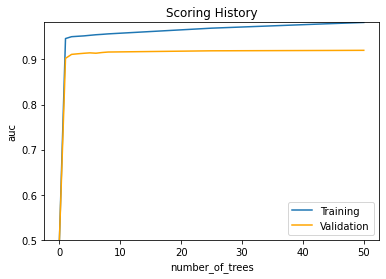

In [47]:
# Define Preditors
predictors = crimeWithWeatherHF.names[:]
response = "Arrest"
predictors.remove(response)

#Simple GBM model - Predict Arrest
model_gbm = H2OGradientBoostingEstimator(ntrees         =50,
                                        max_depth      =6,
                                        learn_rate     =0.1, 
                                        #nfolds         =2,
                                        distribution   ="bernoulli")

model_gbm.train(x               =predictors,
               y               ="Arrest",
               training_frame  =train,
               validation_frame=valid
               )

# Simple Deep Learning - Predict Arrest
model_dl = H2ODeepLearningEstimator(variable_importances=True,
                                   loss                ="Automatic")

model_dl.train(x                =predictors,
              y                ="Arrest",
              training_frame  =train,
              validation_frame=valid)

# Print confusion matrices for the train and validation set
print(model_gbm.confusion_matrix(train = True))
print(model_gbm.confusion_matrix(valid = True))

print(model_gbm.auc(train=True))
print(model_gbm.auc(valid=True))
model_gbm.plot(metric="auc")